In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

2022-08-10 14:26:35.595493: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def AutoEncoder(n_input):
    
    X_in = Input(shape=(n_input,))

    # level 1
    X = Dense(256)(X_in)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # level 3
    X = Dense(128)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # Bottle neck
    X = Dense(70)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # level 4
    X = Dense(128)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # level 5
    X = Dense(256)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # output
    X_out = Dense(n_input, activation='linear')(X)
    model = Model(inputs=X_in, outputs=X_out)
    model.compile(optimizer='adam', loss='mse')

    return model

In [3]:
train = pd.read_pickle('Data/train_data.pkl')
test = pd.read_pickle('Data/test_data.pkl')
data = pd.concat([train, test], axis=0)
data.drop('S_2', axis=1, inplace=True)

cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68",
]

data.drop(cat_features, axis=1, inplace=True)
data.reset_index(drop=False, inplace=True)

num_columns = data.columns.to_list()
num_columns.remove('customer_ID')

for i in num_columns:
    data[i].fillna(data[i].median(), inplace=True)

del train, test; gc.collect()
data.shape

(16895213, 178)

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((data[num_columns], data[num_columns]))
del data; _ = gc.collect()

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

2022-08-10 14:27:38.962888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:27:39.026322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-10 14:27:39.026336: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-10 14:27:39.026731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [5]:
model = AutoEncoder(len(num_columns))

In [6]:
history = model.fit(
    train_dataset,
    epochs=500,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)],
)
model.save('Models/AutoEncoder_bottleneck70.h5')

Epoch 1/500
16500/16500 [==============================] - 197s 12ms/step - loss: 4.3688
Epoch 2/500
16500/16500 [==============================] - 214s 13ms/step - loss: 4.0678
Epoch 3/500
16500/16500 [==============================] - 212s 13ms/step - loss: 3.9215
Epoch 4/500
16500/16500 [==============================] - 226s 14ms/step - loss: 3.8304
Epoch 5/500
16500/16500 [==============================] - 242s 15ms/step - loss: 3.7448
Epoch 6/500
16500/16500 [==============================] - 222s 13ms/step - loss: 3.6842
Epoch 7/500
16500/16500 [==============================] - 208s 13ms/step - loss: 3.6162
Epoch 8/500
16500/16500 [==============================] - 213s 13ms/step - loss: 3.5499
Epoch 9/500
16500/16500 [==============================] - 213s 13ms/step - loss: 3.5215
Epoch 10/500
16500/16500 [==============================] - 204s 12ms/step - loss: 3.4463
Epoch 11/500
16500/16500 [==============================] - 211s 13ms/step - loss: 3.3970
Epoch 12/500
16500/

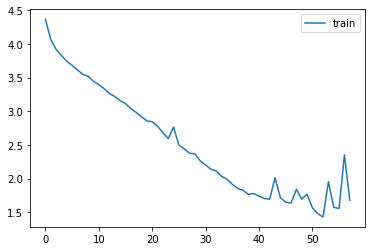

In [7]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [ ]:
model.load_weights('Models/AutoEncoder.h5')

32/32 [==============================] - 0s 1ms/step


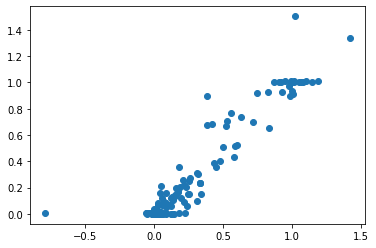

In [8]:
j = 0
for i in train_dataset.take(1):
     value = i[0].numpy()[j]

for i in train_dataset.take(1):
    pred = model.predict(i[0])

plt.scatter(pred[j], value)

In [ ]:
j = 0
for i in train_dataset.take(1):
     value = i[0].numpy()[j]

for i in train_dataset.take(1):
    pred = model.predict(i[0])

plt.scatter(pred[j], value)

In [ ]:
pred = model.predict(train_dataset)
pred.shape

In [ ]:
pred